# EDA Hugging Face Dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import ast

## Data Dictionary
<details>
<summary>Click to expand</summary>

| Column Name     | Description                                                                                     |
|-----------------|-------------------------------------------------------------------------------------------------|
| text            | The text data in each row.                                                                     |
| labels          | The labels associated with each text (e.g., toxic, non-toxic).                                  |
| encoded_labels  | Encoded version of the labels for machine learning models.                                      |
| text_length(added)     | The length of each text in the `text` column, calculated as the number of characters in the text.|
| labels_list(added)     |  Parsed lists of labels                 |

</details>


Data consists of three columns stored in parquet files: 
- encoded labels sotred as strings in single column, will have to be converted to binary array for ML. 

In [18]:
def read_parquet_files(file_path_pattern):
    dfs =[]
    #glob finds all path names matching specified pattern
    for file_name in glob.glob(file_path_pattern):
        df =pd.read_parquet(file_name, engine='pyarrow')
        dfs.append(df)
    return pd.concat(dfs, ignore_index =True)

## Train Data Set

In [19]:
data = read_parquet_files('../data/hugging/train-*.parquet') #use wildcard -* to identify pattern

In [20]:
data.head()

,text,labels,encoded_labels
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]"
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
3,Message from you to an IP \n\nI received a mes...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Misleading and inappropriate citations Used,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344950 entries, 0 to 6344949
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   text            object
 1   labels          object
 2   encoded_labels  object
dtypes: object(3)
memory usage: 145.2+ MB


In [22]:
data.isnull().sum()

text              0
labels            0
encoded_labels    0
dtype: int64

### Text Length

In [23]:
#add column with text length
data['text_length'] = data['text'].apply(len)

In [24]:
data.head(3)

,text,labels,encoded_labels,text_length
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",324
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]",272
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]",99


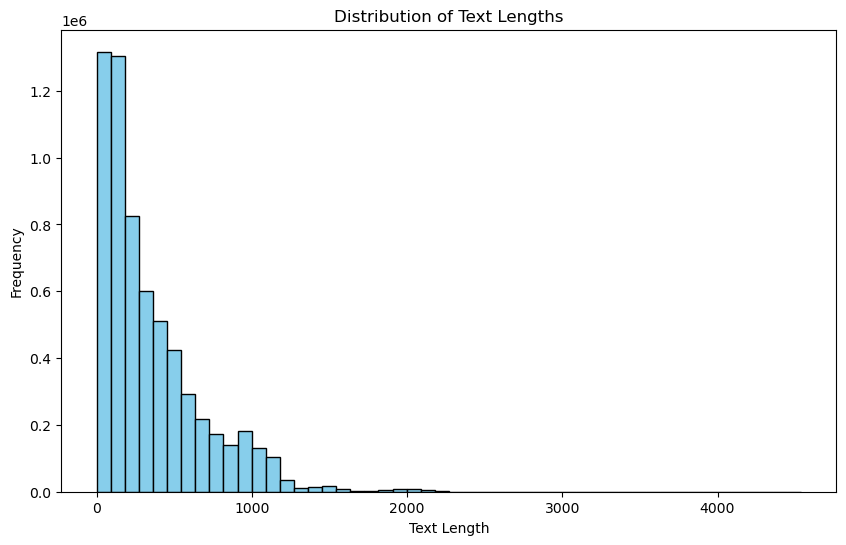

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(data['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


### Label Distribution and Class Imbalance

In [32]:
data.head()

,text,labels,encoded_labels,text_length,labels_list
0,Football positions \n\nHi Mehudson. When you'...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",324,[]
1,Thank you SO MUCH for your Nazi-like oversight...,"[toxic, profane, insult]","[1, 1, 1, 0, 0, 0, 0, 0, 0]",272,[]
2,Darkwind \n Stick it up your arse you offensi...,"[toxic, profane]","[1, 1, 0, 0, 0, 0, 0, 0, 0]",99,[]
3,Message from you to an IP \n\nI received a mes...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",292,[]
4,Misleading and inappropriate citations Used,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",43,[]


In [38]:
#handle empty strings of labels
def safe_literal_eval(x):
    try:
        if isinstance(x, str): 
            if x.startswith('[') and x.endswith(']'):
                return ast.literal_eval(x)
            else:
                return []
        elif isinstance(x, np.ndarray):
            return x.tolist()
        else:
            return []         
    except (SyntaxError, ValueError):
        return []

#ast.literal_eval convert string representation of labels to a list
data['labels_list'] = data['labels'].apply(safe_literal_eval) 
#flatten list
#first part iterate through rows, nested for; iterate through labels in row
all_labels = [label for labels_list in data['labels_list'] for label in labels_list]

#calculate distribution -> convert all_labels to a series to count
label_dist = pd.Series(all_labels).value_counts()

#count occurences of rows without labels
no_label_count = data['labels_list'].apply(lambda x: len(x) == 0).sum() # use lambda func. to count occurence where len of string =0

print("Label distribution:")
print(label_dist)
print("\nNumber of rows without labels:", no_label_count)


Label distribution:
toxic         568042
selfharm      247778
insult        237258
profane        51340
hate           49439
offensive      37329
threat          9065
sexual          8929
harassment      4072
Name: count, dtype: int64

Number of rows without labels: 5436491


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344950 entries, 0 to 6344949
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   text            object
 1   labels          object
 2   encoded_labels  object
 3   text_length     int64 
 4   labels_list     object
dtypes: int64(1), object(4)
memory usage: 242.0+ MB


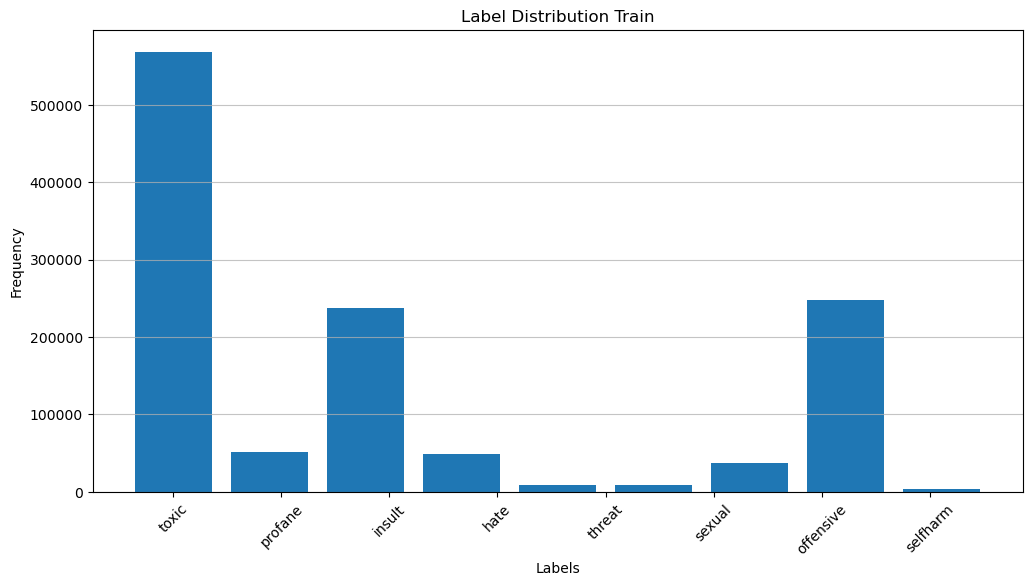

In [42]:
#flatten-> convert list of lists into single list (all_labels is flattened list variable)
# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(all_labels, bins=len(set(all_labels)), align='left', rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution Train')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


Number of occurences of toxic: 568,042 and number of occurences of no label: 5,436,491 -> high class imbalance in dataset

**Co Occurence** For this analysis will look at co-occurance of up to 2 labels

In [44]:
from itertools import combinations

In [61]:
labels = ['toxic','profane','insult','hate','threat','sexual','offensive','selfharm']
#generate combinations of labels(i) for loop creates list of lists -> ea. inner list conatins all comb of i for i from 1-2 
label_combo = sum([list(combinations(labels,i)) for i in range (1,3)],[])
label_combo = [', '.join(comb) for comb in label_combo] 

In [62]:
#initialize co-occurance matrix
co_occur_matrix = pd.DataFrame(0, index=label_combo, columns = labels)

In [63]:
### MATRIX IS NOT populating correctly 
label_data = pd.DataFrame(data['labels_list'])
for idx, row in label_data.iterrows():
    labels_tuple = tuple(row['labels_list'])
    for label_comb in label_combo:
        if len(label_comb) > 1 and all(label in labels_tuple for label in label_comb):
            label_comb_str = ', '.join(label_comb)
            co_occur_matrix.loc[label_comb_str, label_comb_str] += 1

print("Co-occurrence Matrix:")
print(co_occur_matrix)


Co-occurrence Matrix:
                     toxic  profane  insult  hate  threat  sexual  offensive  \
toxic                    0        0       0     0       0       0          0   
profane                  0        0       0     0       0       0          0   
insult                   0        0       0     0       0       0          0   
hate                     0        0       0     0       0       0          0   
threat                   0        0       0     0       0       0          0   
sexual                   0        0       0     0       0       0          0   
offensive                0        0       0     0       0       0          0   
selfharm                 0        0       0     0       0       0          0   
toxic, profane           0        0       0     0       0       0          0   
toxic, insult            0        0       0     0       0       0          0   
toxic, hate              0        0       0     0       0       0          0   
toxic, threat     

In [51]:
data['labels_list'].head()

0                          []
1    [toxic, profane, insult]
2            [toxic, profane]
3                          []
4                          []
Name: labels_list, dtype: object

### Word Frequency

In [43]:
from nltk.tokenize import word_tokenize
from collections import Counter